In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the data
raw_df = pd.read_csv('modes_interaction_logs.csv')

# Function to process interaction logs
def process_interaction_logs(df):
    # Group by experiment_id, step_id and process the data
    processed_steps = []

    for (exp_id, step_id), group in df.groupby(['experiment_id', 'step_id']):
        # Sort by timestamp to get chronological order
        group_sorted = group.sort_values('timestamp')

        # Initial timestamp for the step
        initial_timestamp = group_sorted['timestamp'].min()

        # Mode of the experiment
        mode = group_sorted['mode'].iloc[0]

        # Step name
        step_name = group_sorted['step_name'].iloc[0]

        # Count of navigation actions
        back_count = len(group_sorted[group_sorted['action'] == 'navigate_previous'])

        # Count of suggestion requests
        suggestion_count = len(group_sorted[group_sorted['action'].str.contains('toggle', na=False)])

        # Total interactions
        total_interactions = len(group_sorted[group_sorted['action'].str.contains('toggle|previous|next', na=False)])

        # Check different content views
        short_text_viewed = group_sorted['short_text_viewed'].max()
        long_text_viewed = group_sorted['long_text_viewed'].max()
        single_pieces_viewed = group_sorted['single_pieces_viewed'].max()
        assembly_viewed = group_sorted['assembly_viewed'].max()
        video_viewed = group_sorted['video_viewed'].max()

        # Last timestamp to calculate step completion time
        last_timestamp = group_sorted['timestamp'].max()
        completion_time = (pd.to_datetime(last_timestamp) - pd.to_datetime(initial_timestamp)).total_seconds()

        # Initial and computed suggestions (managing back and previous step navigation)
        initial_suggestion = min(1, group_sorted[group_sorted['action'] == 'initial_suggestion']['timestamp'].count())
        computed_suggestion = min(1, group_sorted[group_sorted['action'] == 'computed_suggestion']['timestamp'].count())

        processed_steps.append({
            'experiment_id': exp_id,
            'mode': mode,
            'step_id': step_id,
            'step_name': step_name,
            'initial_timestamp': initial_timestamp,
            'back_navigation_count': back_count,
            'suggestion_request_count': suggestion_count,
            'total_interactions': total_interactions,
            'completion_time': completion_time,
            'initial_suggestions': initial_suggestion,
            'computed_suggestions': computed_suggestion,
            'short_text_viewed': short_text_viewed,
            'long_text_viewed': long_text_viewed,
            'single_pieces_viewed': single_pieces_viewed,
            'assembly_viewed': assembly_viewed,
            'video_viewed': video_viewed
        })

    return pd.DataFrame(processed_steps)

# Process the interaction logs
df = process_interaction_logs(raw_df)

# Calculate total experiment completion time for each experiment
total_completion_times = raw_df.groupby('experiment_id').apply(
    lambda x: (pd.to_datetime(x['timestamp'].max()) - pd.to_datetime(x['timestamp'].min())).total_seconds()
).reset_index(name='total_experiment_time')

# Merge total completion times with processed dataframe
df = df.merge(total_completion_times, on='experiment_id')

qualitative_metrics = pd.read_csv('modes_qualitative_metrics.csv')
merged_data = df.merge(qualitative_metrics, left_on='experiment_id', right_on='id', how='left')

<ipython-input-1-8b25c8504939>:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_completion_times = raw_df.groupby('experiment_id').apply(


In [2]:
# Comparison between Static and Dynamically Adaptive modes
mode_comparison = df.groupby('mode').agg({
    'completion_time': ['mean', 'median'],
    'back_navigation_count': ['mean', 'sum'],
    'suggestion_request_count': ['mean', 'sum'],
    'total_interactions': ['mean', 'sum'],
    'total_experiment_time': ['mean', 'median']
})
print("\nMode Comparison:")
print(mode_comparison)


Mode Comparison:
                     completion_time            back_navigation_count      \
                                mean     median                  mean sum   
mode                                                                        
Dynamically Adaptive       24.629553  15.740454               0.05000   8   
Rule-Based Adaptive        26.946878  17.122854               0.08125  13   
Static                     26.111597  20.820123               0.06250  10   

                     suggestion_request_count      total_interactions       \
                                         mean  sum               mean  sum   
mode                                                                         
Dynamically Adaptive                  0.38125   61             1.4125  226   
Rule-Based Adaptive                   0.23125   37             1.3250  212   
Static                                0.72500  116             1.7875  286   

                     total_experiment_time        

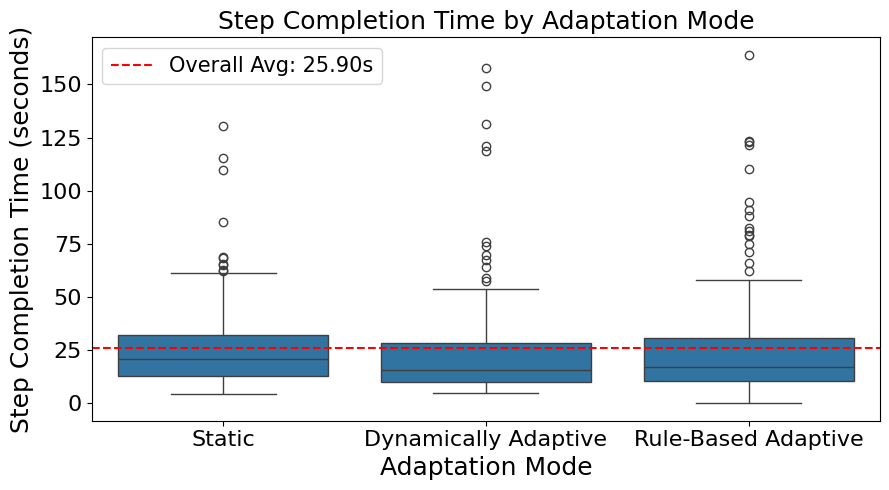

In [3]:
# Calculate the overall average completion time across all modes
overall_avg_time = df['completion_time'].mean()

# Visualization of step completion times by mode
plt.figure(figsize=(9, 5))

# Create the boxplot
sns.boxplot(x='mode', y='completion_time', data=df)

# Plot a single red line for the overall average completion time
plt.axhline(y=overall_avg_time, color='red', linestyle='--', label=f'Overall Avg: {overall_avg_time:.2f}s')

# Title and labels
plt.title('Step Completion Time by Adaptation Mode', fontsize=18)
plt.xlabel('Adaptation Mode', fontsize=18)
plt.ylabel('Step Completion Time (seconds)', fontsize=18)
plt.tick_params(axis='both', labelsize=16)

# Add the legend for the average line
plt.legend(title='', loc='upper left', fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()
plt.close()


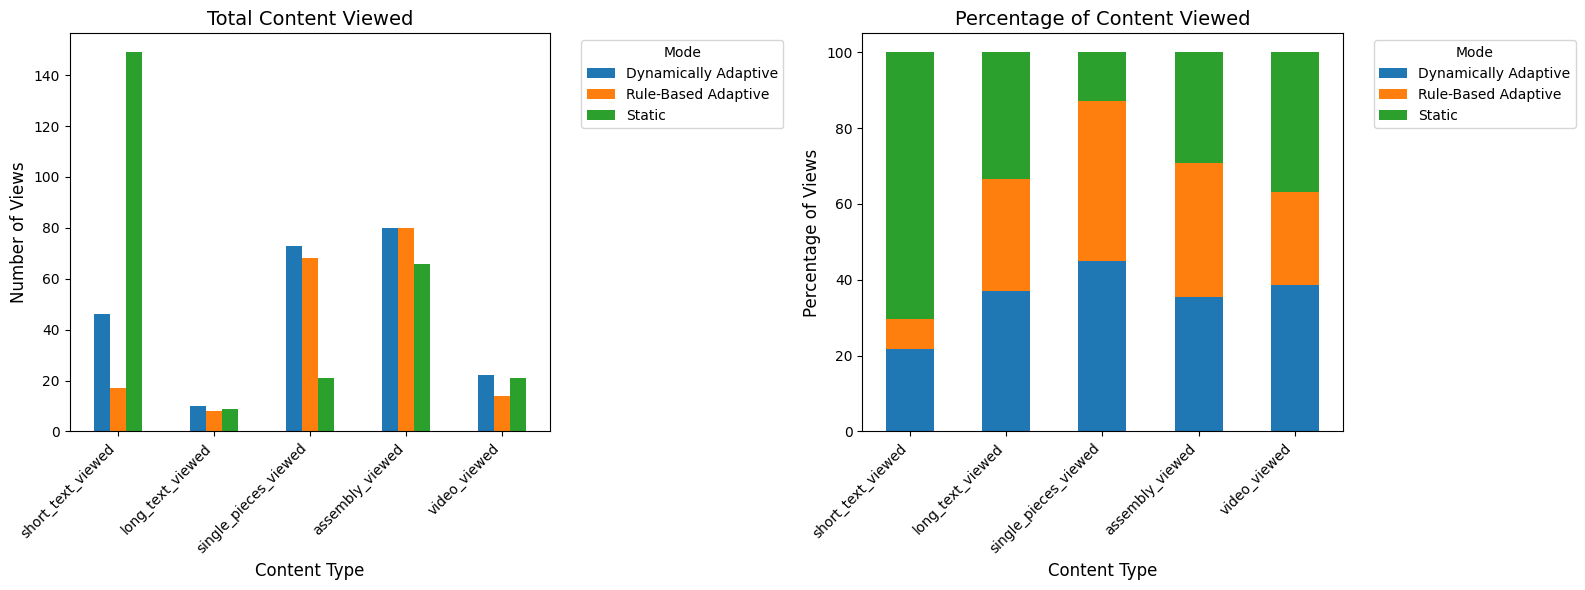

Total Content Viewed by Content Type and Mode:
mode                  Dynamically Adaptive  Rule-Based Adaptive  Static
short_text_viewed                     46.0                 17.0   149.0
long_text_viewed                      10.0                  8.0     9.0
single_pieces_viewed                  73.0                 68.0    21.0
assembly_viewed                       80.0                 80.0    66.0
video_viewed                          22.0                 14.0    21.0

Percentage of Content Viewed by Content Type and Mode:
mode                  Dynamically Adaptive  Rule-Based Adaptive     Static
short_text_viewed                21.698113             8.018868  70.283019
long_text_viewed                 37.037037            29.629630  33.333333
single_pieces_viewed             45.061728            41.975309  12.962963
assembly_viewed                  35.398230            35.398230  29.203540
video_viewed                     38.596491            24.561404  36.842105


In [4]:
# Distribution of content viewed by mode
content_columns = ['short_text_viewed', 'long_text_viewed', 'single_pieces_viewed',
                   'assembly_viewed', 'video_viewed']

# Group by mode and sum the content views
content_viewed_by_mode = merged_data.groupby('mode')[content_columns].sum().T

# Create a figure with two subplots
plt.figure(figsize=(16, 6))

# Absolute Number of Views
plt.subplot(1, 2, 1)
content_viewed_by_mode.plot(kind='bar', ax=plt.gca())
plt.title('Total Content Viewed', fontsize=14)
plt.xlabel('Content Type', fontsize=12)
plt.ylabel('Number of Views', fontsize=12)
plt.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

# Percentage Distribution (Stacked)
plt.subplot(1, 2, 2)
content_viewed_percentage = content_viewed_by_mode.div(content_viewed_by_mode.sum(axis=1), axis=0) * 100
content_viewed_percentage.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Percentage of Content Viewed', fontsize=14)
plt.xlabel('Content Type', fontsize=12)
plt.ylabel('Percentage of Views', fontsize=12)
plt.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
plt.close()

# Print summary
print("Total Content Viewed by Content Type and Mode:")
print(content_viewed_by_mode)
print("\nPercentage of Content Viewed by Content Type and Mode:")
print(content_viewed_percentage)

<ipython-input-5-53e8511a8306>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mode_metric_summary.index, y=mode_metric_summary['mean'],
<ipython-input-5-53e8511a8306>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes_flat[i].set_xticklabels(axes_flat[i].get_xticklabels(), rotation=45, ha='right')
<ipython-input-5-53e8511a8306>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mode_metric_summary.index, y=mode_metric_summary['mean'],
<ipython-input-5-53e8511a8306>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  

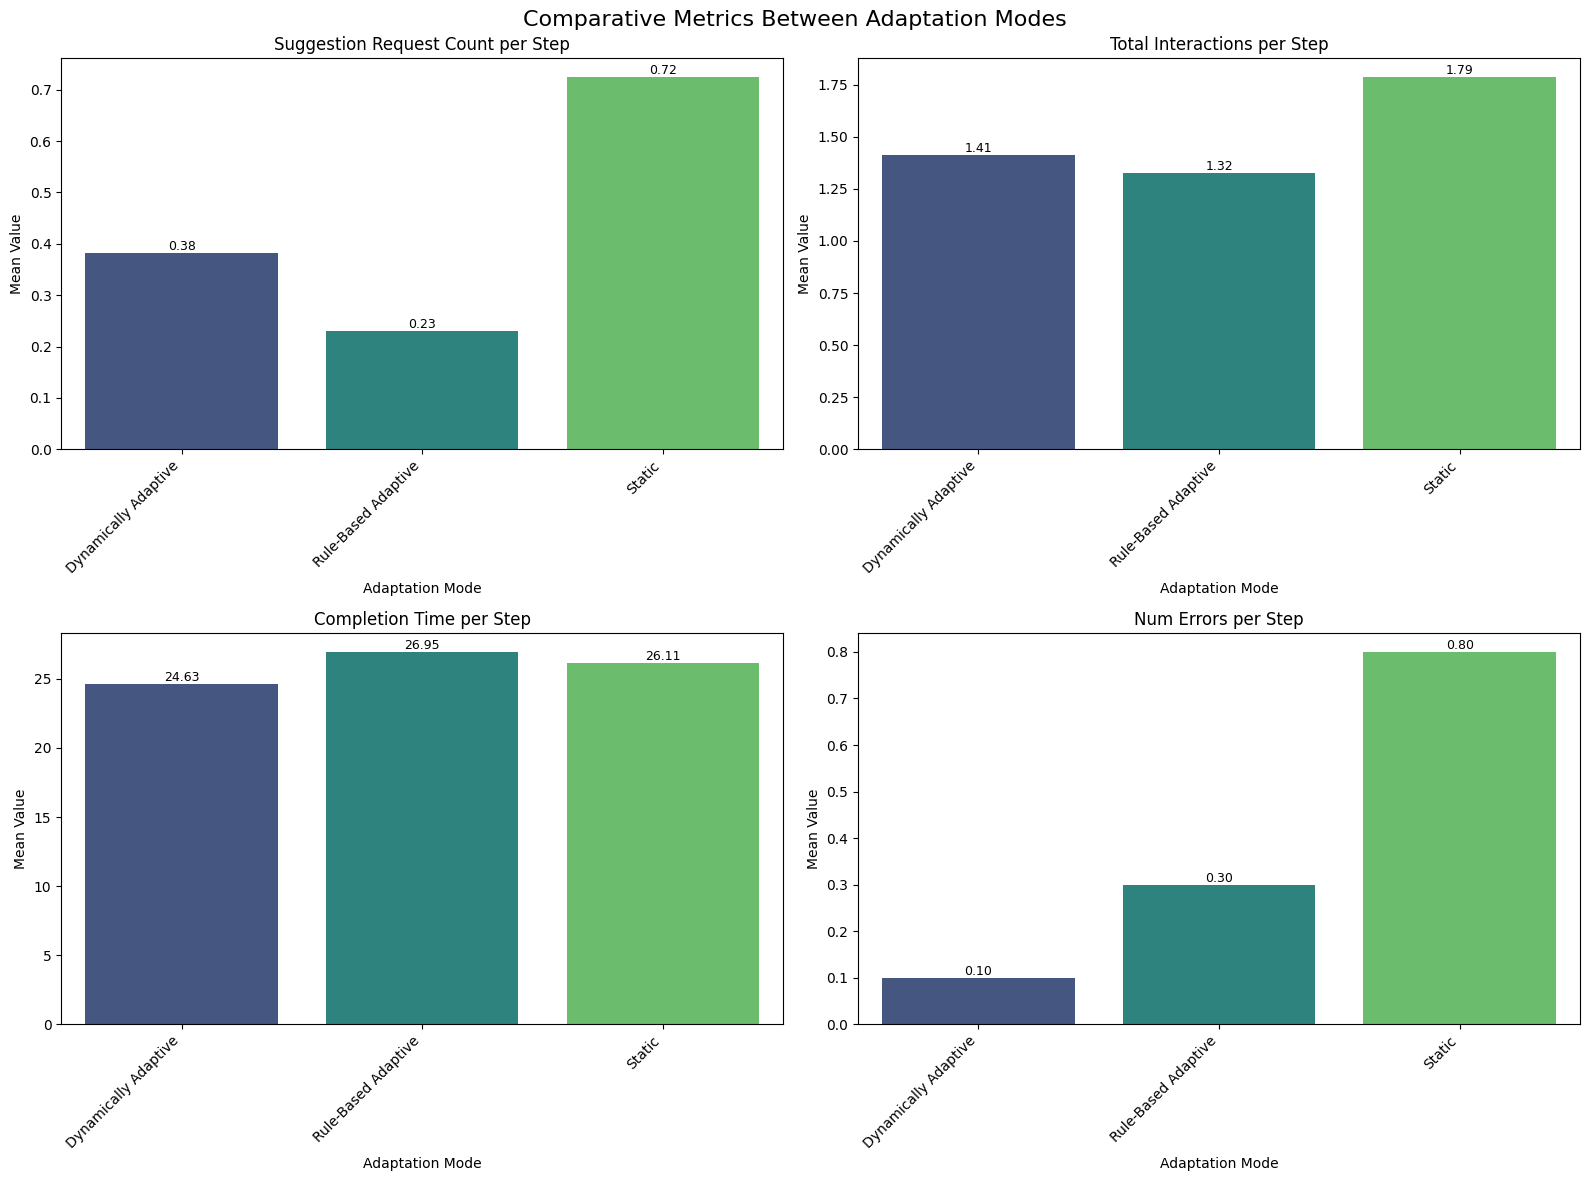

In [5]:
# 2. Comparative Bar Plot for Key Metrics
metrics_to_compare = ['suggestion_request_count', 'total_interactions', 'completion_time', 'num_errors']

# Create a figure with subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparative Metrics Between Adaptation Modes', fontsize=16)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, metric in enumerate(metrics_to_compare):
    # Group by mode and calculate mean
    mode_metric_summary = merged_data.groupby('mode')[metric].agg(['mean', 'median', 'std'])

    # Bar plot
    sns.barplot(x=mode_metric_summary.index, y=mode_metric_summary['mean'],
                ax=axes_flat[i], palette='viridis')

    # Customize the plot
    axes_flat[i].set_title(f'{metric.replace("_", " ").title() + " per Step"}', fontsize=12)
    axes_flat[i].set_xlabel('Adaptation Mode', fontsize=10)
    axes_flat[i].set_ylabel('Mean Value', fontsize=10)

    # Rotate x-axis labels
    axes_flat[i].set_xticklabels(axes_flat[i].get_xticklabels(), rotation=45, ha='right')

    # Add value labels on the bars
    for j, v in enumerate(mode_metric_summary['mean']):
        axes_flat[i].text(j, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
plt.close()

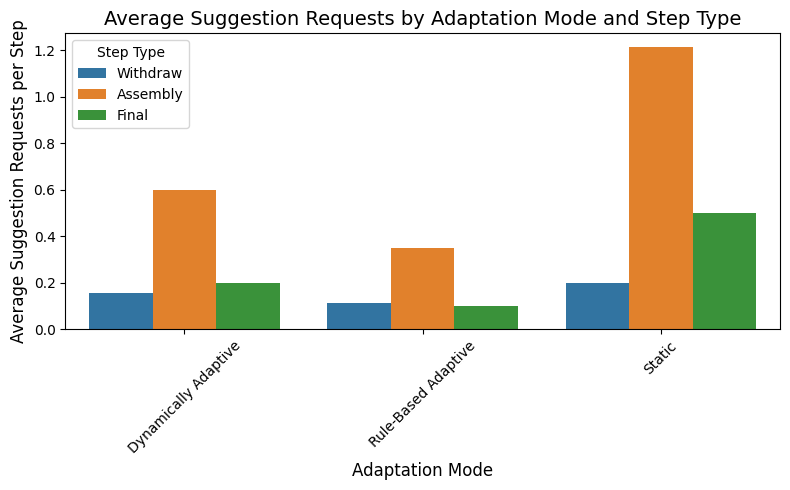

                   mode step_type  avg_suggestion_requests  \
0  Dynamically Adaptive  Assembly                 0.600000   
1  Dynamically Adaptive     Final                 0.200000   
2  Dynamically Adaptive  Withdraw                 0.157143   
3   Rule-Based Adaptive  Assembly                 0.350000   
4   Rule-Based Adaptive     Final                 0.100000   
5   Rule-Based Adaptive  Withdraw                 0.114286   
6                Static  Assembly                 1.212500   
7                Static     Final                 0.500000   
8                Static  Withdraw                 0.200000   

   median_suggestion_requests  total_suggestion_requests  total_steps  \
0                         0.0                         48           80   
1                         0.0                          2           10   
2                         0.0                         11           70   
3                         0.0                         28           80   
4             

In [6]:
# Reuse the previous analysis function
def analyze_suggestions_by_step_type(df):
    # Create a new column to categorize step types
    df['step_type'] = df['step_name'].apply(lambda x: x.split()[0] if pd.notna(x) else 'Unknown')

    # Filter for steps of interest (Assembly, Withdraw, Final)
    target_step_types = ['Withdraw', 'Assembly', 'Final']
    filtered_df = df[df['step_type'].isin(target_step_types)]

    # Analyze suggestion requests
    suggestion_analysis = filtered_df.groupby(['mode', 'step_type']).agg({
        'suggestion_request_count': ['mean', 'median', 'sum'],
        'experiment_id': 'count'
    }).reset_index()

    # Rename columns for clarity
    suggestion_analysis.columns = [
        'mode', 'step_type',
        'avg_suggestion_requests',
        'median_suggestion_requests',
        'total_suggestion_requests',
        'total_steps'
    ]

    # Calculate percentage of steps with suggestions
    suggestion_analysis['suggestion_request_rate'] = (
        suggestion_analysis['total_suggestion_requests'] /
        (suggestion_analysis['total_steps'] * suggestion_analysis['avg_suggestion_requests'])
    ).round(4)

    return suggestion_analysis

# Perform the analysis
suggestion_analysis = analyze_suggestions_by_step_type(df)

# Prepare data for plotting
plt.figure(figsize=(8, 5))

# Specify the order of step types
step_type_order = ['Withdraw', 'Assembly', 'Final']

# Create the bar plot with specified order
sns.barplot(
    x='mode',
    y='avg_suggestion_requests',
    hue='step_type',
    hue_order=step_type_order,
    data=suggestion_analysis
)

plt.title('Average Suggestion Requests by Adaptation Mode and Step Type', fontsize=14)
plt.xlabel('Adaptation Mode', fontsize=12)
plt.ylabel('Average Suggestion Requests per Step', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Step Type', title_fontsize=10)
plt.tight_layout()
plt.show()

# Print the analysis data for reference
print(suggestion_analysis)

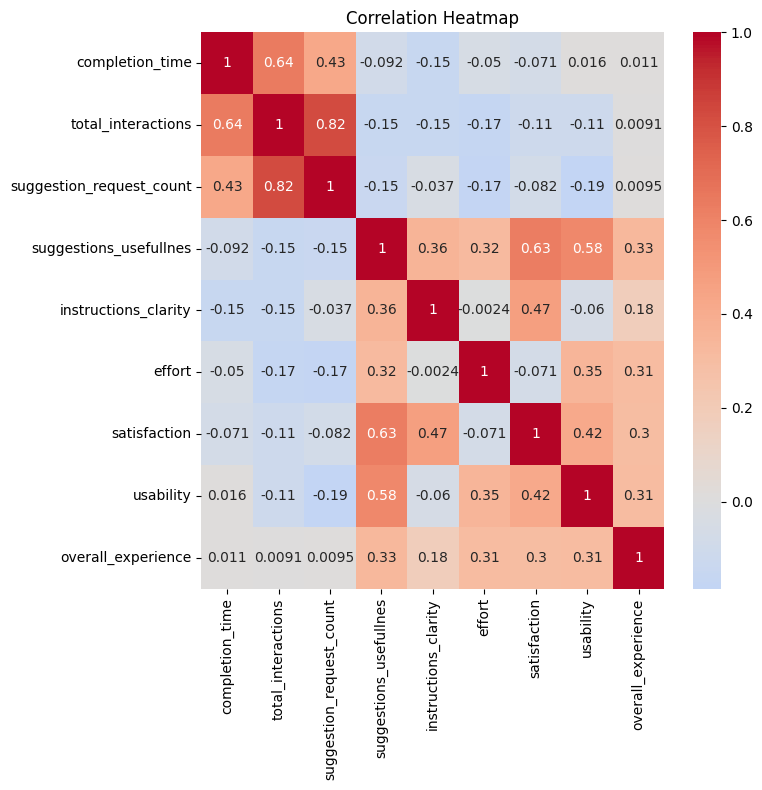

In [7]:
# QUALITATIVE ANALYSIS

correlation_columns = ['completion_time', 'total_interactions', 'suggestion_request_count',
                       'suggestions_usefullnes', 'instructions_clarity', 'effort',
                       'satisfaction', 'usability', 'overall_experience']

# Visualization of Mode Performance
plt.figure(figsize=(8, 8))
correlation_matrix = merged_data[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()
plt.close()

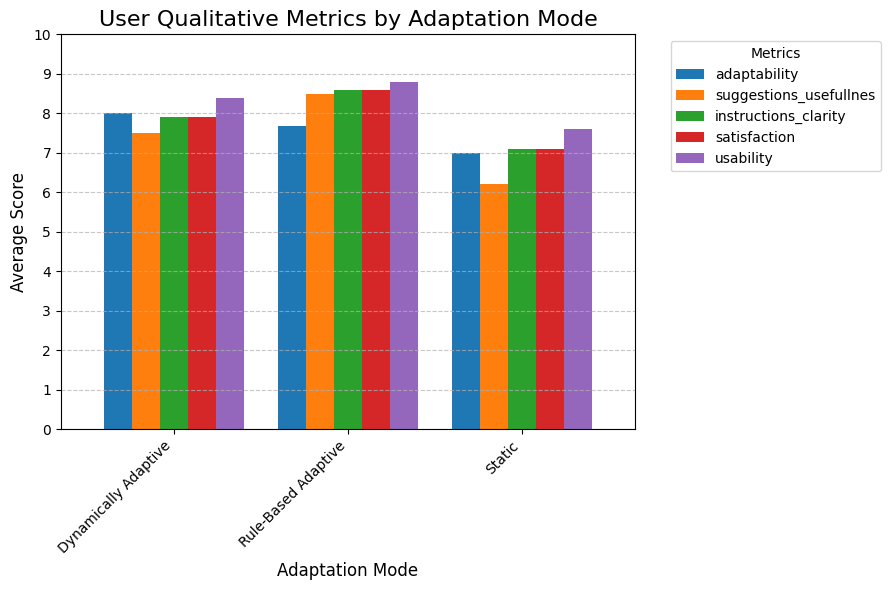

In [8]:
# User Experience Metrics by Mode
plt.figure(figsize=(8, 6))
qualitative_columns = ['adaptability', 'suggestions_usefullnes', 'instructions_clarity', 'satisfaction', 'usability']
# qualitative_columns = ['adaptability', 'suggestions_usefullnes', 'instructions_clarity', 'effort', 'satisfaction', 'usability', 'overall_experience']
mode_exp_metrics = merged_data.groupby('mode')[qualitative_columns].mean()
ax = mode_exp_metrics.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.yticks(range(11))  # This creates ticks from 0 to 10
plt.title('User Qualitative Metrics by Adaptation Mode', fontsize=16)
plt.xlabel('Adaptation Mode', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.8)
plt.show()
plt.close()

<Figure size 1200x1000 with 0 Axes>

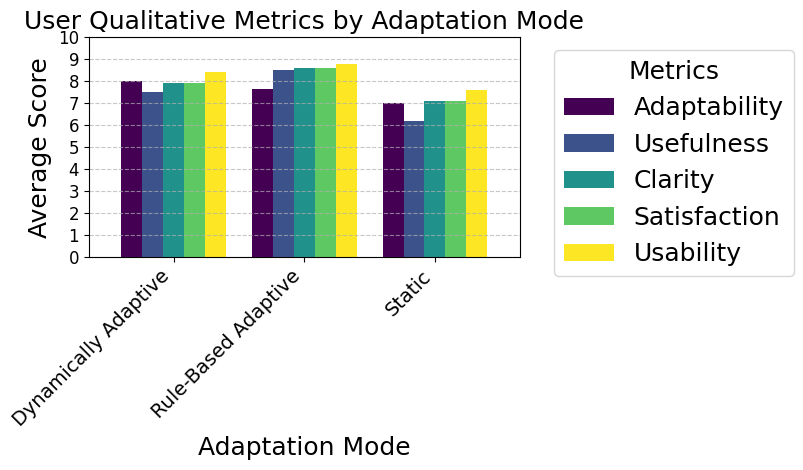

In [9]:
# User Experience Metrics by Mode
plt.figure(figsize=(12, 10))

qualitative_columns = ['adaptability', 'suggestions_usefullnes', 'instructions_clarity', 'satisfaction', 'usability']
legend_labels = ["Adaptability", "Usefulness", "Clarity", "Satisfaction", "Usability"]

# Calculate mean metrics by mode
mode_exp_metrics = merged_data.groupby('mode')[qualitative_columns].mean()

# Get the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(qualitative_columns)))

# Plot with explicit colors from viridis
ax = mode_exp_metrics.plot(
    kind='bar',
    color=colors,
    width=0.8
)

# Set y-axis ticks from 0 to 10
plt.yticks(range(11))  # Creates ticks from 0 to 10

# Customize the plot
plt.title('User Qualitative Metrics by Adaptation Mode', fontsize=18)
plt.xlabel('Adaptation Mode', fontsize=18)
plt.ylabel('Average Score', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust legend with custom labels
ax.legend(
    labels=legend_labels,  # Updating legend labels
    title='Metrics',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=18,
    title_fontsize=18
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.show()


<Figure size 1200x800 with 0 Axes>

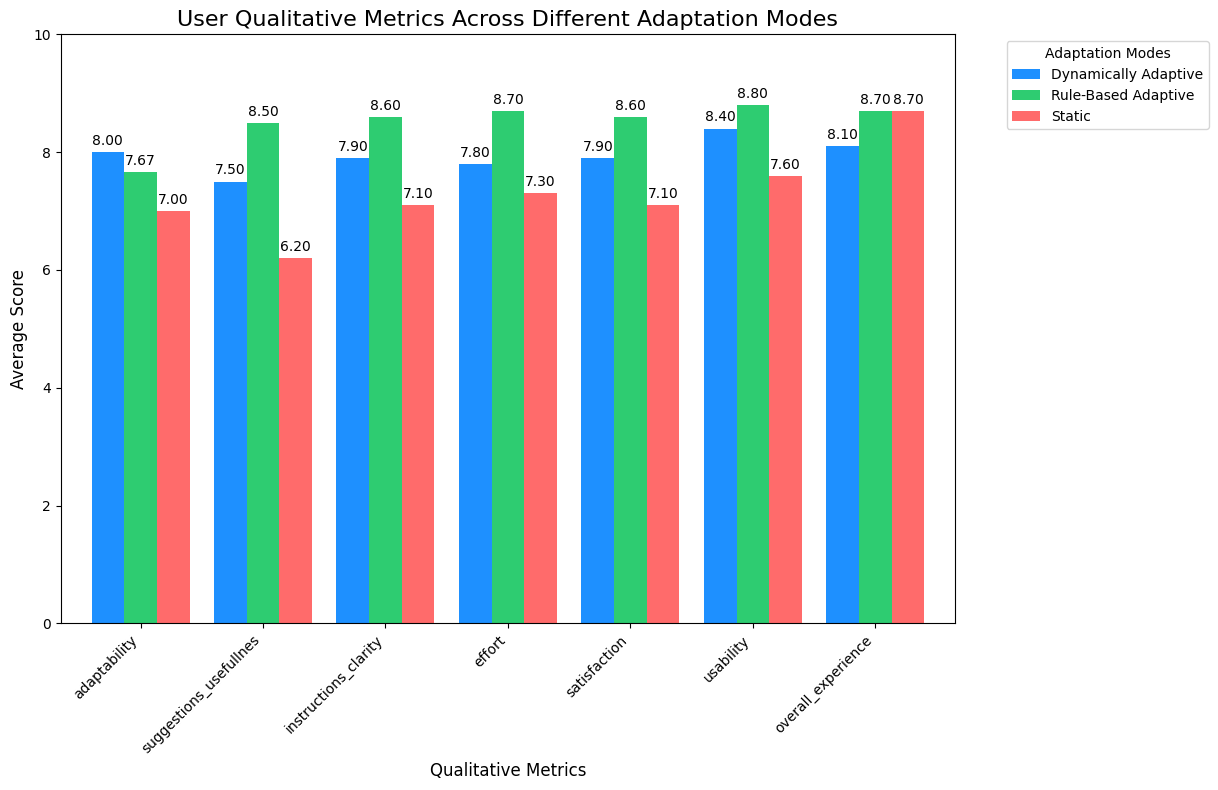

In [10]:
plt.figure(figsize=(12, 8))

# Transpose the metrics to have metrics as columns
qualitative_columns = ['adaptability', 'suggestions_usefullnes', 'instructions_clarity', 'effort', 'satisfaction', 'usability', 'overall_experience']
mode_exp_metrics = merged_data.groupby('mode')[qualitative_columns].mean().T

# Create a color palette for modes
color_palette = ['#1E90FF', '#2ECC71', '#FF6B6B', '#F39C12']

# Plot with explicit color mapping
ax = mode_exp_metrics.plot(kind='bar',
                            figsize=(12, 8),
                            width=0.8,
                            color=color_palette[:len(mode_exp_metrics.columns)])

plt.title('User Qualitative Metrics Across Different Adaptation Modes', fontsize=16)
plt.xlabel('Qualitative Metrics', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 10)  # Assuming metrics are scored out of 10

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.legend(title='Adaptation Modes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.8)
plt.show()
plt.close()

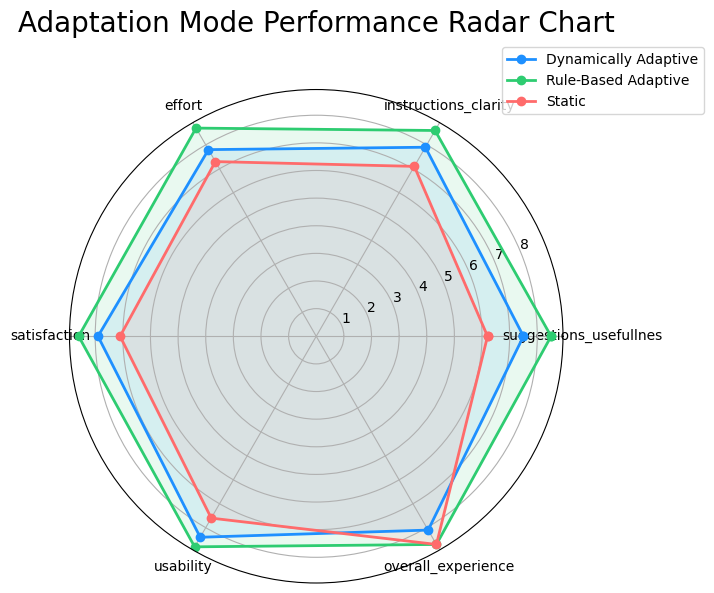

In [11]:
# Mode Performance Radar Chart
plt.figure(figsize=(8, 6))

# Select metrics for radar chart
radar_metrics = [
    'suggestions_usefullnes', 'instructions_clarity', 'effort',
    'satisfaction', 'usability', 'overall_experience'
]

# Normalize the metrics
mode_radar_data = merged_data.groupby('mode')[radar_metrics].mean()

# Plot radar chart
categories = list(mode_radar_data.columns)
N = len(categories)

# Create color palette
colors = ['#1E90FF', '#2ECC71', '#FF6B6B', '#F39C12']

# Plot each mode
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.subplot(polar=True)

for i, (mode, data) in enumerate(mode_radar_data.iterrows()):
    values = data.tolist()
    values += values[:1]
    plt.polar(angles, values, 'o-', linewidth=2, label=mode, color=colors[i])
    plt.fill(angles, values, alpha=0.1, color=colors[i])

plt.xticks(angles[:-1], categories)
plt.title('Adaptation Mode Performance Radar Chart', size=20, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
plt.close()

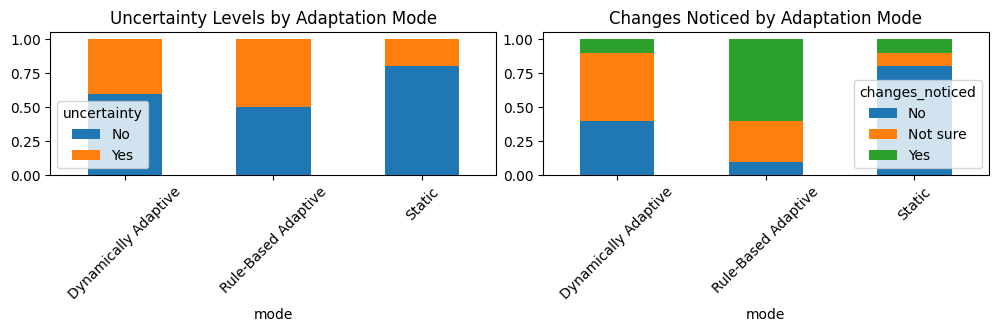

In [12]:
plt.figure(figsize=(10, 5))

# Interaction Metrics by Mode
interaction_metrics = ['total_interactions', 'suggestion_request_count', 'back_navigation_count']
available_interaction_metrics = [col for col in interaction_metrics if col in merged_data.columns]

interaction_by_mode = merged_data.groupby('mode')[available_interaction_metrics].agg(['mean', 'std'])

# 5. Uncertainty and Changes Noticed Analysis
plt.subplot(2, 2, 3)
if 'uncertainty' in merged_data.columns:
    uncertainty_data = merged_data.groupby('mode')['uncertainty'].value_counts(normalize=True).unstack()
    uncertainty_data.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Uncertainty Levels by Adaptation Mode')
    plt.xticks(rotation=45)

# 6. Changes Noticed Analysis
plt.subplot(2, 2, 4)
if 'changes_noticed' in merged_data.columns:
    changes_data = merged_data.groupby('mode')['changes_noticed'].value_counts(normalize=True).unstack()
    changes_data.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Changes Noticed by Adaptation Mode')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
plt.close()

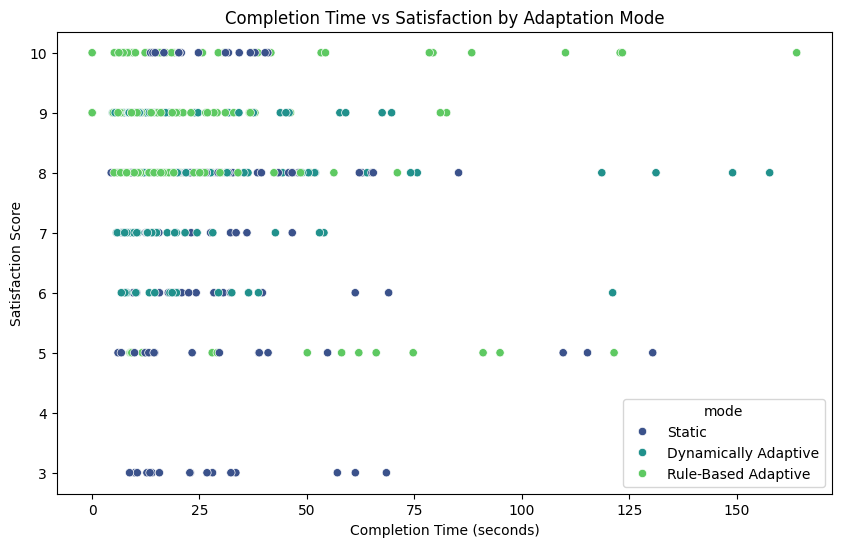

In [13]:
# Completion Time vs Satisfaction
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='completion_time', y='satisfaction', hue='mode', palette='viridis')
plt.title('Completion Time vs Satisfaction by Adaptation Mode')
plt.xlabel('Completion Time (seconds)')
plt.ylabel('Satisfaction Score')
plt.show()
plt.close()

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Metrics to compare
# metrics_to_compare = ['total_interactions', 'suggestion_request_count', 'num_errors']

# # Rename adaptation modes
# mode_mapping = {
#     'Static': 'Static',
#     'Rule-Based Adaptive': 'Pattern-guided',
#     'Dynamically Adaptive': 'Preference-adaptive'
# }

# # Apply renaming
# merged_data['mode'] = merged_data['mode'].replace(mode_mapping)

# # Get unique adaptation modes
# modes = merged_data['mode'].unique()

# # Create figure
# plt.figure(figsize=(10, 6))
# plt.title('Comparison of Quantitative Metrics by Adaptation Mode', fontsize=16)

# # Bar width and positions
# bar_width = 0.15  # Adjusted for multiple modes
# x = np.arange(len(metrics_to_compare))  # X positions for metrics

# # Define colors for each mode
# colors = sns.color_palette('viridis', n_colors=len(modes))

# # Plot bars for each mode
# for i, mode in enumerate(modes):
#     mode_means = [merged_data[merged_data['mode'] == mode][metric].mean() for metric in metrics_to_compare]
#     plt.bar(x + i * bar_width, mode_means, width=bar_width, label=mode, color=colors[i])

# # Customize plot
# plt.xlabel('Metric', fontsize=12)
# plt.ylabel('Mean Value per Step', fontsize=12)
# plt.xticks(x + (bar_width * (len(modes) - 1)) / 2, [metric.replace('_', ' ').title() for metric in metrics_to_compare])  # Center x-ticks
# plt.legend(title='Adaptation Mode', fontsize=12, title_fontsize=14)
# plt.grid(axis='y', linestyle='--', alpha=0.6)

# # Show plot
# plt.tight_layout()
# plt.show()


<ipython-input-15-fe451f13274f>:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mode_exp_metrics = merged_data.groupby('mode')[list(qualitative_metrics.keys())].mean().T


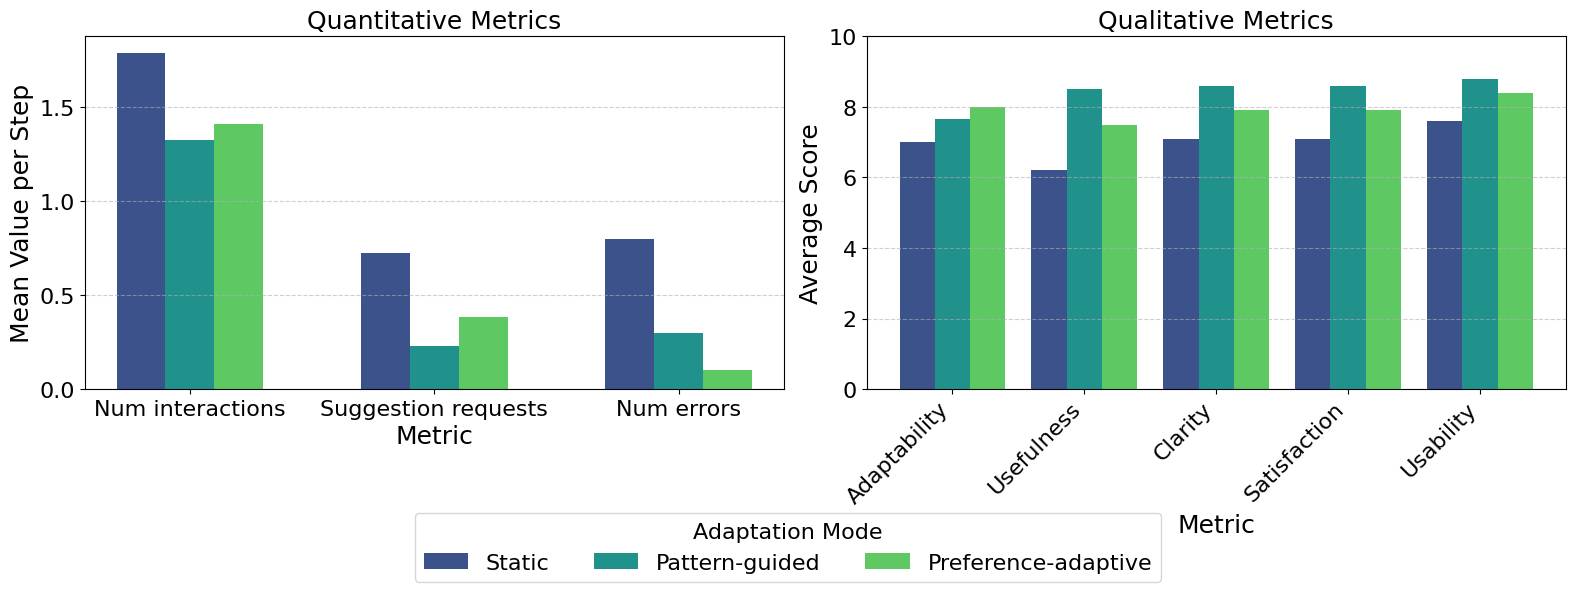

In [15]:
# Metrics to compare
quantitative_metrics = {
    'total_interactions': 'Num interactions',
    'suggestion_request_count': 'Suggestion requests',
    'num_errors': 'Num errors'
}
qualitative_metrics = {
    'adaptability': 'Adaptability',
    'suggestions_usefullnes': 'Usefulness',  # Renamed
    'instructions_clarity': 'Clarity',  # Renamed
    'satisfaction': 'Satisfaction',
    'usability': 'Usability',
}

# Rename adaptation modes
mode_mapping = {
    'Static': 'Static',
    'Rule-Based Adaptive': 'Pattern-guided',
    'Dynamically Adaptive': 'Preference-adaptive'
}

merged_data['mode'] = merged_data['mode'].replace(mode_mapping)

# Define a fixed mode order for consistency
mode_order = ['Static', 'Pattern-guided', 'Preference-adaptive']

# Sort modes accordingly
merged_data['mode'] = pd.Categorical(merged_data['mode'], categories=mode_order, ordered=True)

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
# fig.suptitle('Comparison of Quantitative & Qualitative Metrics by Adaptation Mode', fontsize=20)

# Colors for different adaptation modes
colors = sns.color_palette('viridis', n_colors=len(mode_order))

### FIRST PLOT: Quantitative Metrics ###
x = np.arange(len(quantitative_metrics))  # X positions for metrics
bar_width = 0.2

for i, mode in enumerate(mode_order):  # Ensure consistent ordering
    mode_means = [merged_data[merged_data['mode'] == mode][metric].mean() for metric in quantitative_metrics.keys()]
    axes[0].bar(x + i * bar_width, mode_means, width=bar_width, label=mode, color=colors[i])

axes[0].set_title('Quantitative Metrics', fontsize=18)
axes[0].set_xlabel('Metric', fontsize=18)
axes[0].set_ylabel('Mean Value per Step', fontsize=18)
axes[0].set_xticks(x + (bar_width * (len(mode_order) - 1)) / 2)
axes[0].set_xticklabels(quantitative_metrics.values())
axes[0].tick_params(axis='both', labelsize=16)
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

### SECOND PLOT: Qualitative Metrics ###
mode_exp_metrics = merged_data.groupby('mode')[list(qualitative_metrics.keys())].mean().T
ax2 = mode_exp_metrics.plot(kind='bar', ax=axes[1], width=0.8, color=colors)

axes[1].set_title('Qualitative Metrics', fontsize=18)
axes[1].set_xlabel('Metric', fontsize=18)
axes[1].set_ylabel('Average Score', fontsize=18)
axes[1].set_xticklabels(qualitative_metrics.values(), rotation=45, ha='right')
axes[1].tick_params(axis='both', labelsize=16)
axes[1].set_ylim(0, 10)  # Assuming metrics are scored out of 10
axes[1].grid(axis='y', linestyle='--', alpha=0.6)
# Remove duplicate legend from second plot
ax2.legend_.remove()

# Add common legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title='Adaptation Mode', loc='lower center', ncol=len(mode_order), fontsize=16, title_fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.07, 1, 1])  # Leave space for title & legend
plt.show()


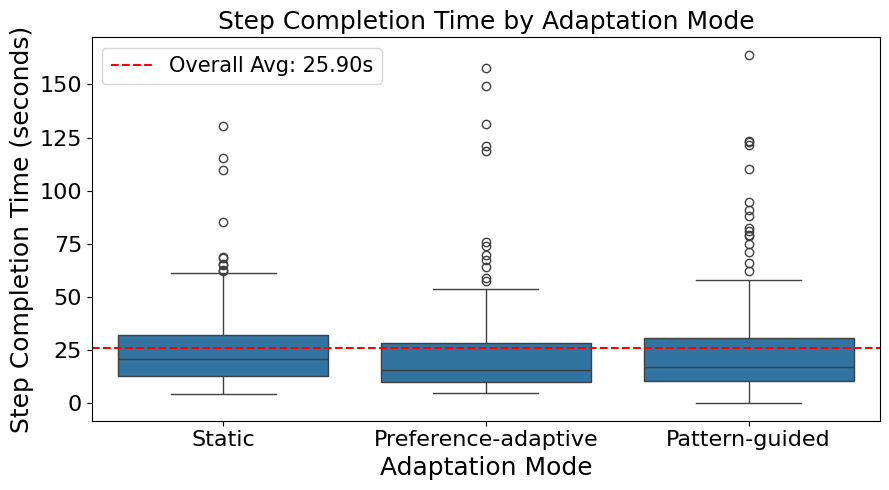

In [16]:
# Mode mapping
mode_mapping = {
    'Static': 'Static',
    'Rule-Based Adaptive': 'Pattern-guided',
    'Dynamically Adaptive': 'Preference-adaptive'
}

# Apply the mode mapping to the 'mode' column
df['mode'] = df['mode'].replace(mode_mapping)

# Calculate the overall average completion time across all modes
overall_avg_time = df['completion_time'].mean()

# Visualization of step completion times by mode
plt.figure(figsize=(9, 5))

# Create the boxplot
sns.boxplot(x='mode', y='completion_time', data=df)

# Plot a single red line for the overall average completion time
plt.axhline(y=overall_avg_time, color='red', linestyle='--', label=f'Overall Avg: {overall_avg_time:.2f}s')

# Title and labels
plt.title('Step Completion Time by Adaptation Mode', fontsize=18)
plt.xlabel('Adaptation Mode', fontsize=18)
plt.ylabel('Step Completion Time (seconds)', fontsize=18)
plt.tick_params(axis='both', labelsize=16)

# Add the legend for the average line
plt.legend(title='', loc='upper left', fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()
plt.close()


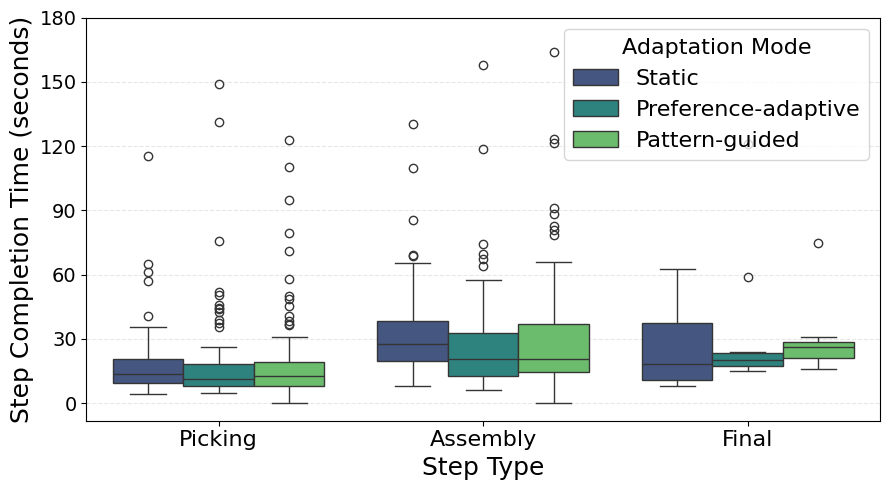

In [17]:
# Make a copy of the dataframe to avoid modifying the original
df_plot = df.copy()

# Rename adaptation modes
mode_mapping = {
    'Static': 'Static',
    'Rule-Based Adaptive': 'Pattern-guided',
    'Dynamically Adaptive': 'Preference-adaptive'
}

# Apply the mode mapping
df_plot['mode'] = df_plot['mode'].replace(mode_mapping)

# Rename step type
df_plot['step_type'] = df_plot['step_type'].replace({'Withdraw': 'Picking'})

# Create the boxplot with mode as a hue (legend) and step_type as x-axis
plt.figure(figsize=(9, 5))
ax = sns.boxplot(
    x='step_type',
    y='completion_time',
    hue='mode',
    data=df_plot,
    palette='viridis'
)

# Title and labels
plt.xlabel('Step Type', fontsize=18)
plt.ylabel('Step Completion Time (seconds)', fontsize=18)
plt.tick_params(axis='both', labelsize=16)

# Set y-axis ticks to include a reasonable range
y_max = df_plot['completion_time'].max() * 1.1  # Add 10% margin
plt.yticks(np.arange(0, y_max, step=30), fontsize=14)

# Enhance the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title='Adaptation Mode',
    fontsize=16,
    title_fontsize=16,
    loc='upper right'
)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()


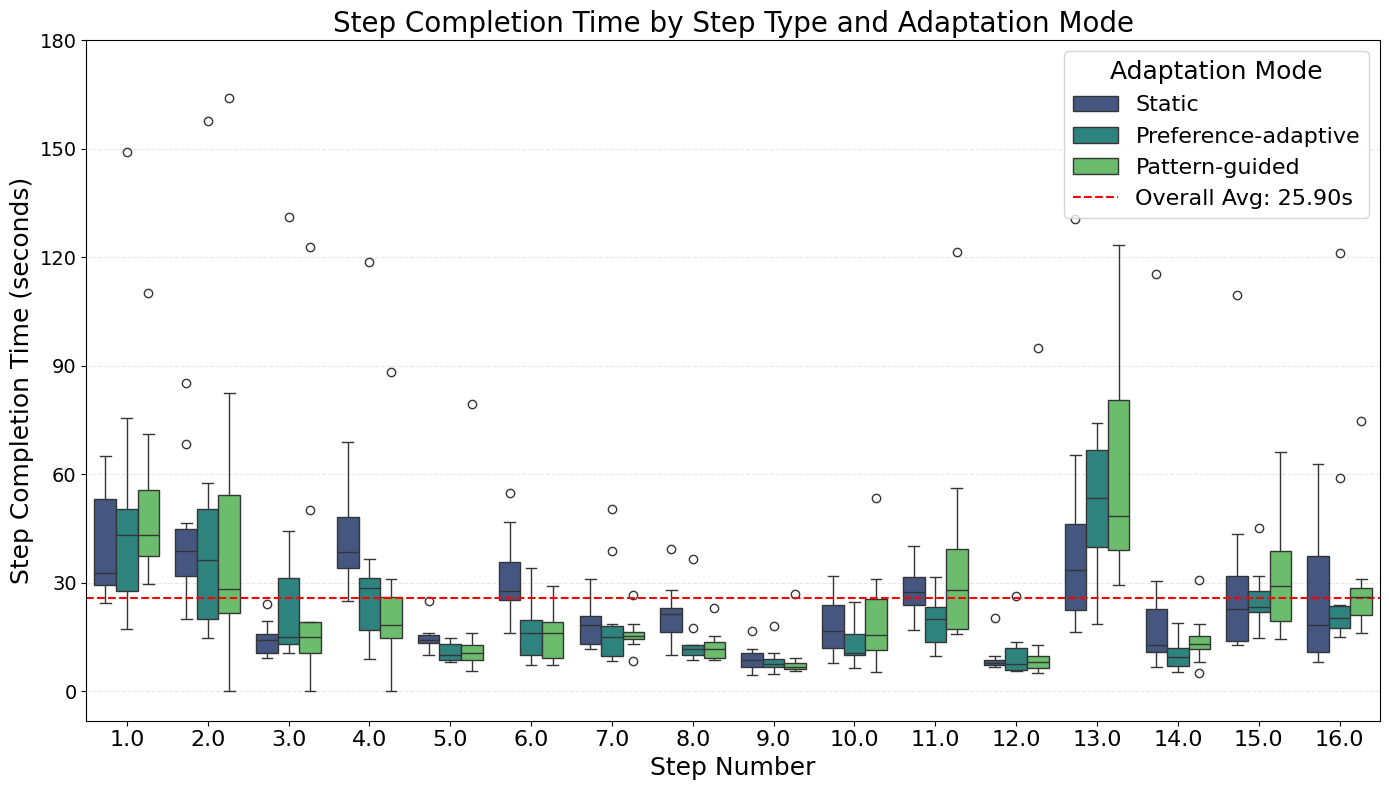

In [18]:
# Visualization of step completion times by step type and mode
plt.figure(figsize=(14, 8))

# Create the boxplot with mode as a hue (legend) and step_type as x-axis
ax = sns.boxplot(
    x='step_id',
    y='completion_time',
    hue='mode',
    data=df,
    palette='viridis'
)

# Calculate the overall average completion time across all modes
overall_avg_time = df['completion_time'].mean()

# Plot a single red line for the overall average completion time
plt.axhline(y=overall_avg_time, color='red', linestyle='--', label=f'Overall Avg: {overall_avg_time:.2f}s')

# Title and labels
plt.title('Step Completion Time by Step Type and Adaptation Mode', fontsize=20)
plt.xlabel('Step Number', fontsize=18)
plt.ylabel('Step Completion Time (seconds)', fontsize=18)
plt.tick_params(axis='both', labelsize=16)

# Set y-axis ticks to include a reasonable range
y_max = df['completion_time'].max() * 1.1  # Add 10% margin
plt.yticks(np.arange(0, y_max, step=30), fontsize=14)  # Adjust step as needed

# Enhance the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title='Adaptation Mode',
    fontsize=16,
    title_fontsize=18,
    loc='upper right'
)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
df

,experiment_id,mode,step_id,step_name,initial_timestamp,back_navigation_count,suggestion_request_count,total_interactions,completion_time,initial_suggestions,computed_suggestions,short_text_viewed,long_text_viewed,single_pieces_viewed,assembly_viewed,video_viewed,total_experiment_time,step_type
0,1.0,Static,1.0,Withdraw Components for PIECE 1,2025-03-27 14:16:42.684540,0,0,1,24.284109,1,0,1.0,0.0,0.0,0.0,0.0,259.266155,Withdraw
1,1.0,Static,2.0,Assembly PIECE 1,2025-03-27 14:17:07.095155,0,1,2,29.971907,1,0,1.0,0.0,0.0,1.0,0.0,259.266155,Assembly
2,1.0,Static,3.0,Withdraw Components for PIECE 2,2025-03-27 14:17:37.201615,0,0,1,9.267918,1,0,1.0,0.0,0.0,0.0,0.0,259.266155,Withdraw
3,1.0,Static,4.0,Assembly PIECE 2,2025-03-27 14:17:46.592704,0,1,2,27.030241,1,0,1.0,0.0,0.0,1.0,0.0,259.266155,Assembly
4,1.0,Static,5.0,Withdraw Components for PIECE 3,2025-03-27 14:18:13.761287,0,0,1,13.165995,1,0,1.0,0.0,0.0,0.0,0.0,259.266155,Withdraw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,30.0,Pattern-guided,12.0,Withdraw Components for PIECE 7,2025-03-28 15:57:36.404115,0,0,1,6.643542,1,0,0.0,0.0,1.0,0.0,0.0,325.973856,Withdraw
476,30.0,Pattern-guided,13.0,Assembly PIECE 7,2025-03-28 15:57:43.196334,0,1,2,33.953965,1,0,0.0,0.0,0.0,1.0,1.0,325.973856,Assembly
477,30.0,Pattern-guided,14.0,Withdraw Components for PIECE 8,2025-03-28 15:58:17.269680,0,0,1,8.065363,1,0,0.0,0.0,1.0,0.0,0.0,325.973856,Withdraw
478,30.0,Pattern-guided,15.0,Assembly PIECE 8,2025-03-28 15:58:25.464617,0,0,1,19.013586,1,0,0.0,0.0,0.0,1.0,0.0,325.973856,Assembly


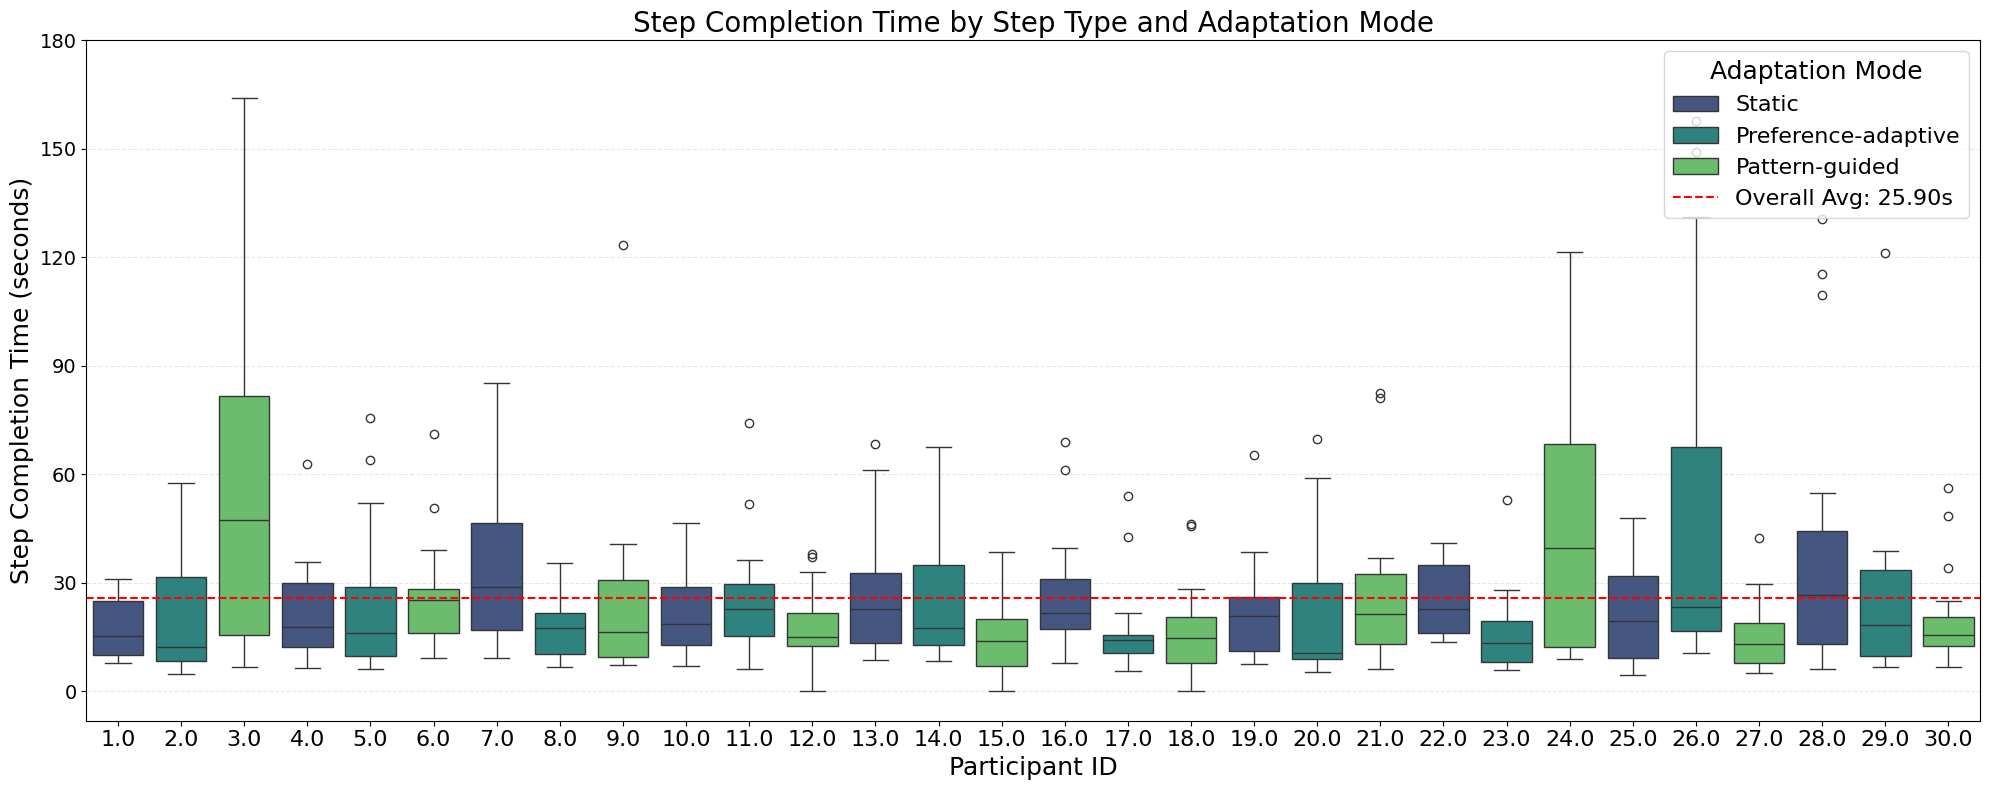

In [20]:
# Visualization of step completion times by step type and mode
plt.figure(figsize=(20, 8))

# Create the boxplot with mode as a hue (legend) and step_type as x-axis
ax = sns.boxplot(
    x='experiment_id',
    y='completion_time',
    hue='mode',
    data=df,
    palette='viridis'
)

# Calculate the overall average completion time across all modes
overall_avg_time = df['completion_time'].mean()

# Plot a single red line for the overall average completion time
plt.axhline(y=overall_avg_time, color='red', linestyle='--', label=f'Overall Avg: {overall_avg_time:.2f}s')

# Title and labels
plt.title('Step Completion Time by Step Type and Adaptation Mode', fontsize=20)
plt.xlabel('Participant ID', fontsize=18)
plt.ylabel('Step Completion Time (seconds)', fontsize=18)
plt.tick_params(axis='both', labelsize=16)

# Set y-axis ticks to include a reasonable range
y_max = df['completion_time'].max() * 1.1  # Add 10% margin
plt.yticks(np.arange(0, y_max, step=30), fontsize=14)  # Adjust step as needed

# Enhance the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title='Adaptation Mode',
    fontsize=16,
    title_fontsize=18,
    loc='upper right'
)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

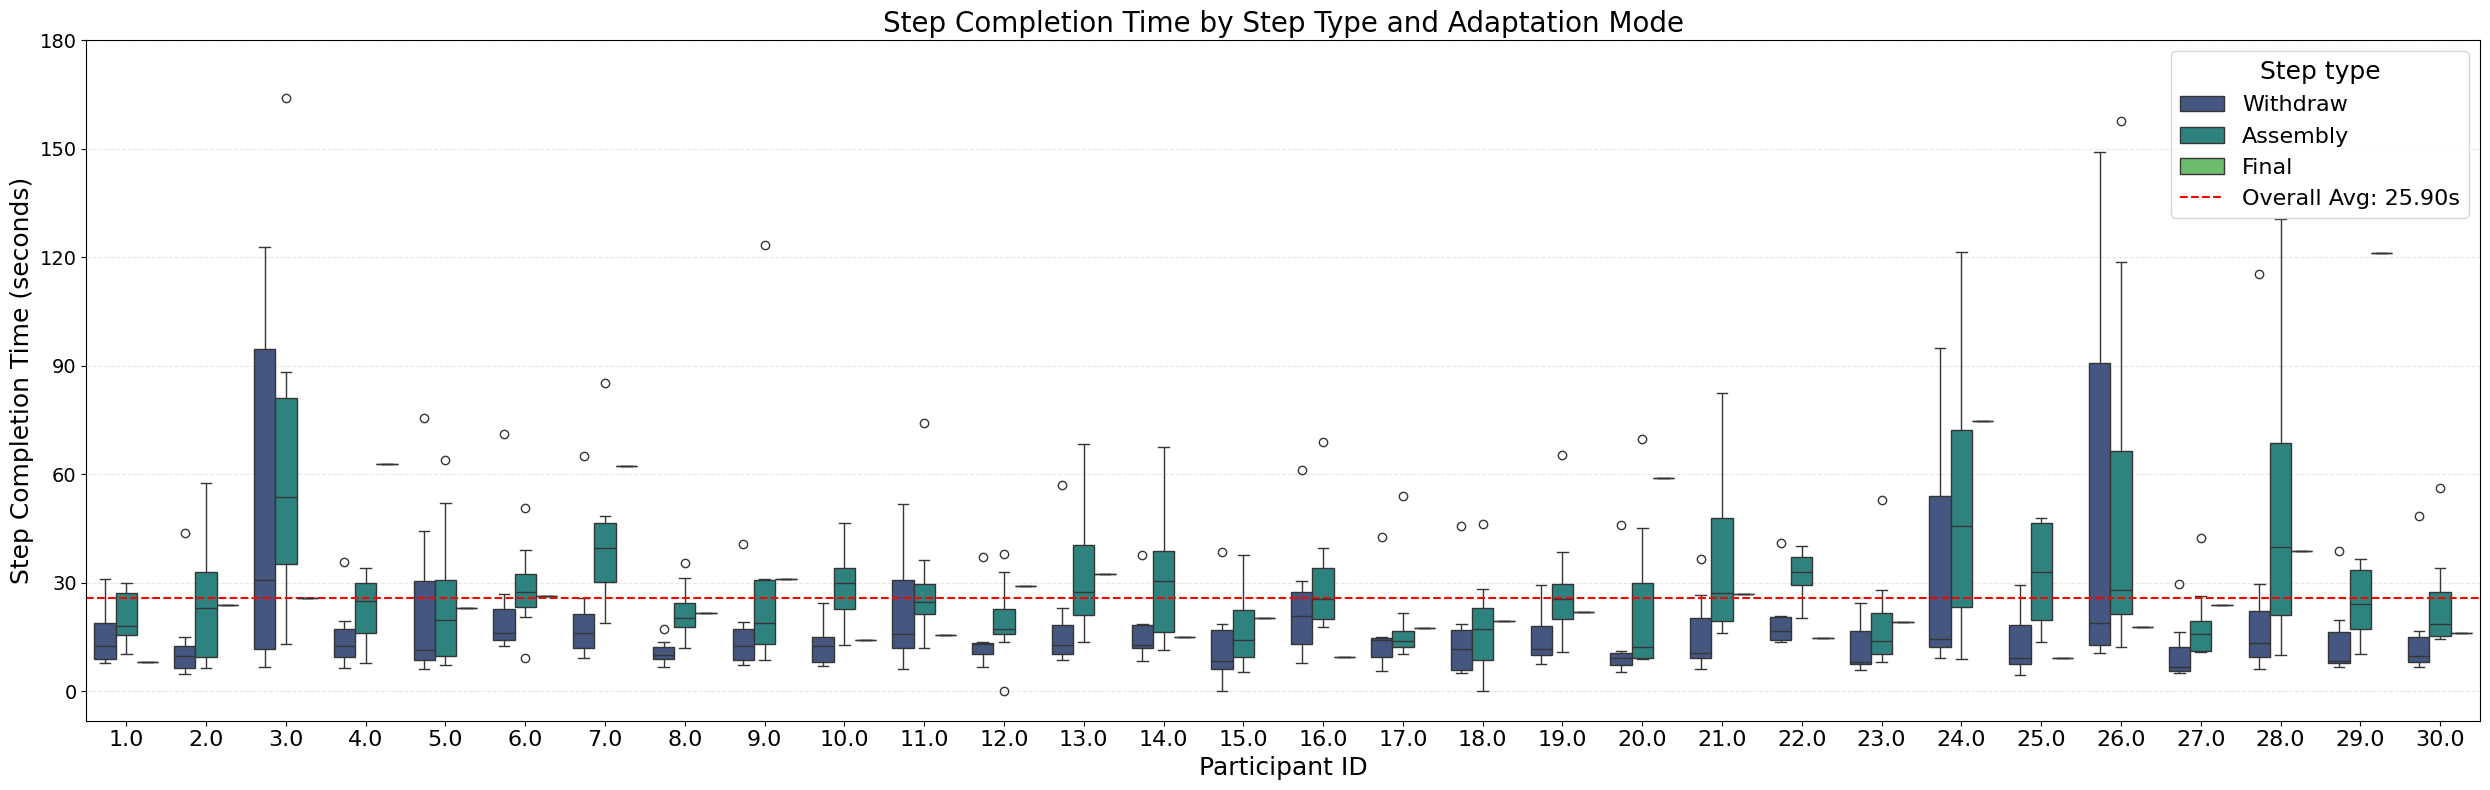

In [21]:
# Visualization of step completion times by step type and mode
plt.figure(figsize=(25, 8))

# Create the boxplot with mode as a hue (legend) and step_type as x-axis
ax = sns.boxplot(
    x='experiment_id',
    y='completion_time',
    hue='step_type',
    data=df,
    palette='viridis'
)

# Calculate the overall average completion time across all modes
overall_avg_time = df['completion_time'].mean()

# Plot a single red line for the overall average completion time
plt.axhline(y=overall_avg_time, color='red', linestyle='--', label=f'Overall Avg: {overall_avg_time:.2f}s')

# Title and labels
plt.title('Step Completion Time by Step Type and Adaptation Mode', fontsize=20)
plt.xlabel('Participant ID', fontsize=18)
plt.ylabel('Step Completion Time (seconds)', fontsize=18)
plt.tick_params(axis='both', labelsize=16)

# Set y-axis ticks to include a reasonable range
y_max = df['completion_time'].max() * 1.1  # Add 10% margin
plt.yticks(np.arange(0, y_max, step=30), fontsize=14)  # Adjust step as needed

# Enhance the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title='Step type',
    fontsize=16,
    title_fontsize=18,
    loc='upper right'
)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()